In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import operator
import statsmodels.api as sm

utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [3]:
def read_data(path):
    df = pd.read_csv(path)

    df.train_size = df.train_size.astype(int)
    df.random_seed = df.random_seed.astype(int)
    df.multiplier = df.multiplier.astype(float)
    for i in range(5):
        df[f"ext_bpoints_in_{chr(i+ord('a'))}"] = df[f"ext_bpoints_in_{chr(i+ord('a'))}"].astype(int)

    # lisame mugavusväärtused
    df["points_in_equal_regions"] = (df["train_size"] / 5).astype(int)
    df["points_in_diff_region"] = (
        df["points_in_equal_regions"] * df["multiplier"]).astype(int)
    df["total_points"] = 4*df["points_in_equal_regions"] + df["points_in_diff_region"]

    # tuunime välja väga kauged väärtused:
    cols_to_process = [*[f'abs_diff_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'rel_diff_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'raw_mean2_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'raw_mean3_in_{chr(a)}' for a in range(97, 97+5)],
                    *['mse_treeningul', 'mse_grid_testil', 'mse_treening_andmete_teine_myra'],
                    ]

    df[cols_to_process] = df.loc[:, cols_to_process][np.abs(stats.zscore(df.loc[:, cols_to_process])) < 3]
    df.dropna(inplace=True)

    df.sort_values(by=["train_size", "region", "multiplier", "random_seed"], inplace=True, ignore_index=True)
    df = df.groupby(['region', 'multiplier', 'train_size']).mean().reset_index()

    df["combo_name"] = df["train_size"].astype(str) + "_" + df["region"] + "_" + df["multiplier"].astype(str)
    return df

paths = ["andmed/all_four/const_order.csv", "andmed/all_four/const_reverse.csv", "andmed/all_four/sin_order.csv", "andmed/all_four/sin_reverse.csv"]
df = read_data(paths[0])


```new_transform ```võtab sisse dataFrame, enda piirkonna, naaber- ja kaugedpiirkonnad.
Jätab alles vaid osa andmetest:
<!-- - my_bpoints
- my_points
- my_points_m1
- my_points_log

- neighbour_bpoints
- neighbour_raw_mean2
- neighbour_points
- neighbour_points_m1
- neighbour_points_log

- distant_bpoints
- distant_raw_mean2
- distant_points
- distant_points_m1
- distant_points_log

- mse_treeningul -->

|   | my  |  naaber | kauge  |   
|---|---|---|---|
| raw_mean2  |   |   |   |   
| breakpoints  |   |   |   |   
| points  |   |   |   |   
| m1  |   |   |   |   
| log  |   |   |   |   

In [4]:
def new_transform(df, minu:str, naabrid:list[str], kaugemad:list[str]):
    ma_olen_reg = minu
    # naabrid = ['a','c']
    naabrid_upper = [n.upper() for n in naabrid]
    # kaugemad = ['d','e']
    kaugemad_upper = [k.upper() for k in kaugemad]


    # y_col = "rel_diff_in_"+ma_olen_reg

    df_new = pd.DataFrame()
    df_new["my_bpoints"] = df["bpoints_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_bpoints"] = (df["bpoints_in_"+naabrid[0]] + df["bpoints_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_bpoints"] = df["bpoints_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_bpoints"] = (df["bpoints_in_"+kaugemad[0]] + df["bpoints_in_"+kaugemad[1]])/2
    else:
        df_new["distant_bpoints"] = df["bpoints_in_"+kaugemad[0]]


    df_new["my_rel_diff"] = df["rel_diff_in_"+ma_olen_reg]

    df_new["my_raw_mean2"] = df["raw_mean2_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_raw_mean2"] = (df["raw_mean2_in_"+naabrid[0]] + df["raw_mean2_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_raw_mean2"] = df["raw_mean2_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_raw_mean2"] = (df["raw_mean2_in_"+kaugemad[0]] + df["raw_mean2_in_"+kaugemad[1]])/2
    else:
        df_new["distant_raw_mean2"] = df["raw_mean2_in_"+kaugemad[0]]

    # minus olevad punktid
    df_new["my_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == ma_olen_reg.upper())) + (df["train_size"]/5 * (df["region"] != ma_olen_reg.upper()))
    df_new["my_points"] = df_new["my_points"].astype(int)

    if len(naabrid) == 2:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[1])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[1]))
        df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)
    else:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] = df_new["neighbour_points"].astype(int)	

    if len(kaugemad) == 2:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[1])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[1]))
        df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)
    else:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] = df_new["distant_points"].astype(int)
    
    # et ei oleks ühtegi nulli enam
    df_new["my_points"] = (df_new["my_points"]+1).astype(float)
    df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
    df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


    df_new["my_points_m1"] = df_new["my_points"] ** (-1)
    # df_new["my_points_m2"] = df_new["my_points"] ** (-2)
    # df_new["my_points_m3"] = df_new["my_points"] ** (-3)
    # df_new["my_points_m4"] = df_new["my_points"] ** (-4)
    # df_new["my_points_m5"] = df_new["my_points"] ** (-5)
    # df_new["my_points_m6"] = df_new["my_points"] ** (-6)
    df_new["my_points_log"] = np.log(df_new["my_points"])


    df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
    # df_new["neighbour_points_m2"] = df_new["neighbour_points"] ** (-2)
    # df_new["neighbour_points_m3"] = df_new["neighbour_points"] ** (-3)
    # df_new["neighbour_points_m4"] = df_new["neighbour_points"] ** (-4)
    # df_new["neighbour_points_m5"] = df_new["neighbour_points"] ** (-5)
    # df_new["neighbour_points_m6"] = df_new["neighbour_points"] ** (-6)
    df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])


    df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
    # df_new["distant_points_m2"] = df_new["distant_points"] ** (-2)
    # df_new["distant_points_m3"] = df_new["distant_points"] ** (-3)
    # df_new["distant_points_m4"] = df_new["distant_points"] ** (-4)
    # df_new["distant_points_m5"] = df_new["distant_points"] ** (-5)
    # df_new["distant_points_m6"] = df_new["distant_points"] ** (-6)
    df_new["distant_points_log"] = np.log(df_new["distant_points"])

    df_new["mse_treeningul"] = df["mse_treeningul"]
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)


    X = df_new.drop(columns=['my_rel_diff'])
    y = df_new['my_rel_diff']

    uuritavad_col = X.columns

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    return X, y

df_order = read_data(paths[0])
uus_x, uus_y = new_transform(df_order, 'b', ['a','c'], ['d'])

uus_x.head()

,my_bpoints,neighbour_bpoints,distant_bpoints,my_raw_mean2,neighbour_raw_mean2,distant_raw_mean2,my_points,neighbour_points,distant_points,my_points_m1,my_points_log,neighbour_points_m1,neighbour_points_log,distant_points_m1,distant_points_log,mse_treeningul
0,0.786540,0.661417,0.173611,0.099200,0.266899,0.196170,0.00125,0.000000,0.00125,0.332917,0.148896,1.000000,0.000000,0.332917,0.148896,0.434014
1,0.757432,0.000000,0.555556,0.340877,0.255393,0.378296,0.00250,0.001001,0.00250,0.199500,0.218129,0.665999,0.065233,0.199500,0.218129,0.416949
2,0.850110,0.193049,0.383142,0.488457,0.381060,0.680474,0.00375,0.002002,0.00375,0.142321,0.263731,0.498999,0.111517,0.142321,0.263731,0.614349
3,0.644384,0.288775,0.306848,0.640313,0.566303,0.742816,0.00500,0.004004,0.00500,0.110556,0.297792,0.331999,0.176751,0.110556,0.297792,0.567813
4,0.414602,0.447069,0.270062,0.782012,0.462185,0.757815,0.00625,0.005005,0.00625,0.090341,0.324989,0.284284,0.201551,0.090341,0.324989,0.602476


In [5]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

In [6]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(df,r,n,k):
    
    X, y = new_transform(df, r,n,k)

    kasutusel_featured = {col: 1 for col in X.columns}


    insignificant_feature = True
    while insignificant_feature:
        
        # model = sm.OLS(y, X)
        model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    
    # print(results.rsquared, sep=";", end=";")
    # print(results.mse_model, sep=";", end=";")
    # print(results.aic, sep=";", end=";")
    # print(results.bic, sep=";", end=";")
    print(results.summary())
    return results, X


X, y = new_transform(df_order, 'b', ['a','c'], ['d'])
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    df_ide_list = []
    print("koik", sep=";", end=";")

    for r, n, k in regioonide_combod:

        #print(r, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)

        mega_df = pd.concat([read_data(paths[p])
                    for p in kombo], ignore_index=True)
        df_ide_list.append(mega_df)
    suur_df = pd.concat(df_ide_list, ignore_index=True)
    res, X = kogu_asi(suur_df, r,n,k)

        # kogu_asi(X, y, r,n,k)
        #print()
    print()
    break

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;neighbour_points_m1;neighbour_points_log;distant_points_m1;distant_points_log;mse_treeningul;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
koik;Dropping feature: distant_points
1;1;1;1;1;1;1;1;0;1;1;1;1;1;1;1;                               SARIMAX Results                                
Dep. Variable:            my_rel_diff   No. Observations:                 9480
Model:                          ARIMA   Log Likelihood                3621.278
Date:                Thu, 20 Apr 2023   AIC                          -7208.556
Time:                        01:26:28   BIC                          -7086.888
Sample:                             0   HQIC                         -7167.262
                               - 9480                                         
Covariance Type:                  opg                         

## Katse 2

In [7]:
def transform_no_scaling(df, minu:str, naabrid:list[str], kaugemad:list[str]):
    ma_olen_reg = minu
    # naabrid = ['a','c']
    naabrid_upper = [n.upper() for n in naabrid]
    # kaugemad = ['d','e']
    kaugemad_upper = [k.upper() for k in kaugemad]

    # y_col = "rel_diff_in_"+ma_olen_reg

    df_new = pd.DataFrame()
    df_new["my_bpoints"] = df["bpoints_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_bpoints"] = (df["bpoints_in_"+naabrid[0]] + df["bpoints_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_bpoints"] = df["bpoints_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_bpoints"] = (df["bpoints_in_"+kaugemad[0]] + df["bpoints_in_"+kaugemad[1]])/2
    else:
        df_new["distant_bpoints"] = df["bpoints_in_"+kaugemad[0]]

    df_new["my_rel_diff"] = df["rel_diff_in_"+ma_olen_reg]

    df_new["my_raw_mean2"] = df["raw_mean2_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_raw_mean2"] = (df["raw_mean2_in_"+naabrid[0]] + df["raw_mean2_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_raw_mean2"] = df["raw_mean2_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_raw_mean2"] = (df["raw_mean2_in_"+kaugemad[0]] + df["raw_mean2_in_"+kaugemad[1]])/2
    else:
        df_new["distant_raw_mean2"] = df["raw_mean2_in_"+kaugemad[0]]

    # minus olevad punktid
    df_new["my_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == ma_olen_reg.upper())) + (df["train_size"]/5 * (df["region"] != ma_olen_reg.upper()))
    df_new["my_points"] = df_new["my_points"].astype(int)

    if len(naabrid) == 2:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[1])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[1]))
        df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)
    else:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] = df_new["neighbour_points"].astype(int)	

    if len(kaugemad) == 2:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[1])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[1]))
        df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)
    else:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] = df_new["distant_points"].astype(int)
    
    # et ei oleks ühtegi nulli enam
    df_new["my_points"] = (df_new["my_points"]+1).astype(float)
    df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
    df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


    df_new["my_points_m1"] = df_new["my_points"] ** (-1)
    df_new["my_points_log"] = np.log(df_new["my_points"])
    df_new["my_points_logm1"] = (np.log(df_new["my_points"])+1.0) ** (-1)

    df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
    df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])
    df_new["neighbour_points_logm1"] = (np.log(df_new["neighbour_points"]) +1.0)** (-1)


    df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
    df_new["distant_points_log"] = np.log(df_new["distant_points"])
    df_new["distant_points_logm1"] = (np.log(df_new["distant_points"]) +1.0) ** (-1)


    df_new["mse_treeningul"] = df["mse_treeningul"]
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)

    df_new.drop_duplicates(inplace=True, ignore_index=True)
    
    X = df_new.drop(columns=['my_rel_diff'])
    y = df_new['my_rel_diff']

    # uuritavad_col = X.columns

    # scaler = MinMaxScaler()
    # X = scaler.fit_transform(X,)
    # X = pd.DataFrame(X, columns=uuritavad_col)

    return X, y#, df.train_size, df.multiplier

In [15]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    # print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def treeni_ols(X, y):
    a = 5/0
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    while insignificant_feature:
        
        model = sm.OLS(y, X)
        # model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y

def treeni_ols_constant(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    X = sm.add_constant(X)
    kasutusel_featured = {col: 1 for col in X.columns}
    # print(kasutusel_featured)

    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        # model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y

### Katsetame decision tree regressori kõige olulisemaid feature

In [94]:
kombo = (0,1,2,3)

Xid, yid = [],[]
tsizes = []

for r, n, k in regioonide_combod:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    # X, y, train_size = transform_no_scaling(andmestikud_koos, r, n, k)
    Xid.append(X)
    yid.append(y)      
    # tsizes.append(train_size)
        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
# tsizes = pd.concat(tsizes, ignore_index=True)

uuritavad_col = X.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)


In [172]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
minix, testx, miniy, testy = train_test_split(suurX, suury, test_size=0.2)
dtr.fit(minix, miniy)
dtr.score(testx, testy)

l = sorted(list(zip(minix.columns, dtr.feature_importances_)), key=lambda x: x[1], reverse=True)
for f, co in l:
    print(f"{f:<25} {co}")


my_raw_mean2              0.18116247309306388
my_bpoints                0.17493473020181607
my_points                 0.16023390662747525
distant_raw_mean2         0.15333309492529193
neighbour_raw_mean2       0.11091079881061304
mse_treeningul            0.10401224117638139
distant_bpoints           0.050885844994619144
neighbour_bpoints         0.018631181962336353
my_points_log             0.017026423403273684
my_points_m1              0.011504572375040557
distant_points_m1         0.005566618041448533
neighbour_points_m1       0.0038723727355524
distant_points            0.0029836706429079607
distant_points_log        0.002040220584329549
neighbour_points          0.0017041657891680476
neighbour_points_log      0.001197684636682265


In [173]:
from sklearn.inspection import permutation_importance
model = Lasso(alpha=0.00001)
minix, X_val, miniy, y_val = train_test_split(suurX, suury, test_size=0.2)
model.fit(minix, miniy)

r = permutation_importance(model, X_val, y_val,
                           n_repeats=100,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{minix.columns[i]:<20}, {r.importances_mean[i]:.3f}, +/- {r.importances_std[i]:.3f}")

my_points_log       , 0.515, +/- 0.022
my_bpoints          , 0.173, +/- 0.012
distant_raw_mean2   , 0.135, +/- 0.011
mse_treeningul      , 0.135, +/- 0.010
neighbour_raw_mean2 , 0.107, +/- 0.009
distant_points_log  , 0.073, +/- 0.007
neighbour_bpoints   , 0.066, +/- 0.007
distant_bpoints     , 0.040, +/- 0.005
distant_points_m1   , 0.018, +/- 0.004
neighbour_points_m1 , 0.012, +/- 0.003


## Blokkhaaval teeme asju

### Ainult my_points jätame sisse

In [169]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a','c'], ['d'])
X = X.loc[:, ~X.columns.str.contains('neighbour_points')]
X = X.loc[:, ~X.columns.str.contains('distant_points')]
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("regular;m1;log;logm1")


for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [],[]

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)      
            

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, ~suurX.columns.str.contains('neighbour_points')]
    suurX = suurX.loc[:, ~suurX.columns.str.contains('distant_points')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_points' in result.params:
        print(result.params.my_points, end=";")
    else:
        print("0", end=";")
    
    if 'my_points_m1' in result.params:
        print(result.params.my_points_m1, end=";")
    else:
        print("0", end=";")
    if 'my_points_log' in result.params:
        print(result.params.my_points_log, end=";")
    else:
        print("0", end=";")
    if "my_points_logm1" in result.params:
        print(result.params.my_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    #print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;my_points_m1;my_points_log;my_points_logm1;mse_treeningul;r2;mse;aic;bic;regular;m1;log;logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;1;1;1;1;1;1;1;1;0.4719766289101591;23.966152638311588;-3722.5003176827067;-3645.599979806358;-0.17091170252149748;0.3660069061541727;0.30331042489470744;-0.9967139029311676;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;0;1;1;1;1;0.5018022424849631;14.617600133244654;-1923.9020830235859;-1860.9117112074553;0;1.3674235082441424;-0.16742854356973552;-2.174239476625729;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;0;1;1;1;0.5856952429004713;15.65322467128181;-2993.93675401563;-2930.9712888126237;-0.1364519917045291;0;0.5812255821392041;-0.4141743951579583;
Komboks oli: (0, 2)
koik;1;1;1;1;1;1;1;1;1;1;1;0.8014617899846425;11.1946826789257;-8207.211789855179;-8137.908707766799;-0.23418019313940466;0.5179194077332178;0.09891437114390014;-1.2559904300318947;
K

### Ainult neighbour_points jätame sisse

In [173]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a','c'], ['d'])
X = X.loc[:, ~X.columns.str.contains('my_points')]
X = X.loc[:, ~X.columns.str.contains('distant_points')]
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("regular;m1;log;logm1")


for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [],[]

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)      
            

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, ~suurX.columns.str.contains('my_points')]
    suurX = suurX.loc[:, ~suurX.columns.str.contains('distant_points')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)
    if 'neighbour_points' in result.params:
        print(result.params.neighbour_points, end=";")
    else:
        print("0", end=";")
    
    if 'neighbour_points_m1' in result.params:
        print(result.params.neighbour_points_m1, end=";")
    else:
        print("0", end=";")
    if 'neighbour_points_log' in result.params:
        print(result.params.neighbour_points_log, end=";")
    else:
        print("0", end=";")
    if "neighbour_points_logm1" in result.params:
        print(result.params.neighbour_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    #print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;neighbour_points;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;mse_treeningul;r2;mse;aic;bic;regular;m1;log;logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;1;1;1;1;0;1;1;1;0.44189544406144043;24.682550607868258;-3279.5919451701757;-3209.682547100768;-0.15521499338042985;0;0.24420263000194967;-0.7096307460066156;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;0;1;1;1;1;0.48448145851225954;14.11304221645758;-1786.5138831015083;-1723.5235112853777;0;1.248493429632295;-0.24711482083954378;-2.1111284742989076;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;0;1;1;1;0.543615721804467;14.528612160321691;-2606.036065849771;-2543.070600646765;-0.24312117379036086;0;0.5761337926329504;-0.42302772531376015;
Komboks oli: (0, 2)
koik;1;1;1;1;1;1;1;1;0;1;1;0.7668038548899492;11.781645156031587;-7561.595936925301;-7498.593135026775;-0.12677606473719089;0.2815493811575743;0;-1.115107099911454;
Komb

### Ainult distant_points jätame sisse

In [175]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a','c'], ['d'])
X = X.loc[:, ~X.columns.str.contains('my_points')]
X = X.loc[:, ~X.columns.str.contains('neighbour_points')]
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("regular;m1;log;logm1")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [],[]

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)      
            

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, ~suurX.columns.str.contains('my_points')]
    suurX = suurX.loc[:, ~suurX.columns.str.contains('neighbour_points')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)
    if 'distant_points' in result.params:
        print(result.params.distant_points, end=";")
    else:
        print("0", end=";")
    
    if 'distant_points_m1' in result.params:
        print(result.params.distant_points_m1, end=";")
    else:
        print("0", end=";")
    if 'distant_points_log' in result.params:
        print(result.params.distant_points_log, end=";")
    else:
        print("0", end=";")

    if "distant_points_logm1" in result.params:
        print(result.params.distant_points_logm1, end=";")
    else:
        print("0", end=";")
    

    print()
    #print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;distant_points;distant_points_m1;distant_points_log;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;regular;m1;log;logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;1;1;1;1;1;1;1;1;0.4255036624524994;21.606336199410293;-3045.144313696166;-2968.2439758198175;-0.21810700380267065;0.23654522630400993;0.24583948403044653;-0.8559577625850862;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;0;1;1;1;1;0.4682100791749594;13.639053667520159;-1661.5913583717138;-1598.6009865555832;0;1.415907041097574;-0.29444467807390484;-2.2035707601503045;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;0;1;1;1;0.5387016417061795;14.39727901264195;-2563.089520359071;-2500.1240551560645;-0.2763890818759437;0;0.5951830709670369;-0.3807300642373222;
Komboks oli: (0, 2)
koik;1;1;0;1;1;1;1;1;1;1;1;0.7581704190255146;11.64899574747231;-7415.273730152128;-7352.270928253602;-0.16455660612399736;0.4373841720387945;0.04863330308338085

### Ainult logm1 jätame sisse

In [220]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X.drop(columns=['my_points', 'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
                'neighbour_points_m1', 'neighbour_points_log', 'distant_points_m1', 'distant_points_log', ], inplace=True)
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_logm1;neighbour_logm1;distant_logm1")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX.drop(columns=['my_points', 'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
               'neighbour_points_m1', 'neighbour_points_log', 'distant_points_m1', 'distant_points_log', ], inplace=True)
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_points_logm1' in result.params:
        print(result.params.my_points_logm1, end=";")
    else:
        print("0", end=";")
    if 'neighbour_points_logm1' in result.params:
        print(result.params.neighbour_points_logm1, end=";")
    else:
        print("0", end=";")

    if "distant_points_logm1" in result.params:
        print(result.params.distant_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())


predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points_logm1;neighbour_points_logm1;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_logm1;neighbour_logm1;distant_logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;0;1;1;1;1;0;1;0.46100472452761254;32.187400313062156;-3563.353255031254;-3507.4257365757276;-0.7181551058763314;-0.281865015578134;0;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;1;1;1;1;0.48600356075187967;14.157381360480738;-1798.4007532803626;-1735.410381464232;-0.6982853867013922;-0.34882122760022327;0.14051113005025817;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;1;1;1;0.5587375653125718;14.932756835808755;-2741.15454576534;-2678.189080562334;-0.7949583512062731;-0.23926609112158687;-0.20461790105654332;
Komboks oli: (0, 2)
koik;1;1;1;1;1;1;1;1;1;1;0.8048347295569493;12.365974861004723;-8278.179500912642;-8215.176699014115;-0.5680629462675039;-0.19507751227393444;-0.1471810312188738;
Komboks oli: (1, 3)
koik;1;1;1;1;1;1;1

## staatiline transform logm1 (my, naaber, distant)

### kaalude leidmine logm1 jaoks

In [243]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X = X.loc[:, X.columns.str.contains('logm1')]

kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_logm1;neighbour_logm1;distant_logm1")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, suurX.columns.str.contains('logm1')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_points_logm1' in result.params:
        print(result.params.my_points_logm1, end=";")
    else:
        print("0", end=";")
    if 'neighbour_points_logm1' in result.params:
        print(result.params.neighbour_points_logm1, end=";")
    else:
        print("0", end=";")

    if "distant_points_logm1" in result.params:
        print(result.params.distant_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())

predict_region;my_points_logm1;neighbour_points_logm1;distant_points_logm1;r2;mse;aic;bic;my_bp;neighbour_bp;distant_bp
Komboks oli: (0, 1, 2, 3)
koik;1;1;0;0.23157253370588704;64.6736785748929;-727.5991177129126;-713.617238099031;-0.5534349575998917;-0.1064246737444824;0;
Komboks oli: (0, 1)
koik;1;1;1;0.1601248395344591;15.54822914649707;161.56768281086806;180.46479435570726;-0.5069606255592207;-0.23045744961998238;0.18556245530272694;
Komboks oli: (2, 3)
koik;1;0;0;0.3234429446673449;86.44299475861163;-1045.3727973869327;-1039.076250866632;-0.7588494465985919;0;0;
Komboks oli: (0, 2)
koik;1;1;1;0.535067303962824;27.40367509319675;-4798.294692759691;-4779.393852190134;-0.4308952542401919;-0.19754387095039433;-0.12594006432845978;
Komboks oli: (1, 3)
koik;1;0;1;0.1253629084325235;25.380644521651078;1655.2955172823613;1667.8861150013663;-0.7674711251965046;0;0.2094020560417894;
Komboks oli: 0
koik;1;1;1;0.5287701981045776;10.123658686511936;-2972.886644611617;-2956.0540862404314;-0.270

### staatiliseks tegemine logm1

In [249]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)


# logm1 pointide transform
coef2 = (-0.553434958 * (suurX.my_points_logm1 - np.min(suurX.my_points_logm1))) / (suurX.my_points_logm1 * (np.max(suurX.my_points_logm1)-np.min(suurX.my_points_logm1)))
my_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_logm1
my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (-0.106424674 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (0.0 * (suurX.distant_points_logm1 - np.min(suurX.distant_points_logm1))) / (suurX.distant_points_logm1 * (np.max(suurX.distant_points_logm1)-np.min(suurX.distant_points_logm1)))
distant_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_logm1
distant_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

suurX["logm1_combo"] = my_points_logm1_kordajaga_ja_scaleeritud+neighbour_points_logm1_kordajaga_ja_scaleeritud+distant_points_logm1_kordajaga_ja_scaleeritud

suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
       'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)

In [250]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [251]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;0;1;1;1;0.6017222593029221;7.107873418697254;-1670.9476675470987;-1633.2771542855517;

In [252]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.600
Method:                 Least Squares   F-statistic:                              345.1
Date:                Wed, 19 Apr 2023   Prob (F-statistic):                   3.44e-314
Time:                        22:50:38   Log-Likelihood:                          842.47
No. Observations:                1606   AIC:                                     -1671.
Df Residuals:                    1599   BIC:                                     -1633.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
my_bpoints           -0.2158      0.038     -5.745      0.000      -0.289      -0.142
neighbour_bpoints    -0.3654      0.032    -11.280      0.000      -0.429      -0.302
distant_bpoints      -0.4961      0.022    -22.265      0.000      -0.540      -0.452
my_raw_mean2          0.9020      0.026     35.354      0.000       0.852       0.952
distant_raw_mean2    -0.6086      0.063     -9.683      0.000      -0.732      -0.485
mse_treeningul       -0.1503      0.037     -4.020      0.000      -0.224      -0.077
logm1_combo           0.1460      0.029      5.102      0.000       0.090       0.202
==============================================================================
Omnibus:                       78.779   Durbin-Watson:                   0.465
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.750
Skew:                          -0.522   Prob(JB):                     7.24e-21
Kurtosis:                       3.543   Cond. No.                         24.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## staatiline transform bpointidele

### bpointide kaalude leidmine

In [232]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X = X.loc[:, X.columns.str.contains('bpoints')]

kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_bp;neighbour_bp;distant_bp")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, suurX.columns.str.contains('bpoints')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_bpoints' in result.params:
        print(result.params.my_bpoints, end=";")
    else:
        print("0", end=";")
    if 'neighbour_bpoints' in result.params:
        print(result.params.neighbour_bpoints, end=";")
    else:
        print("0", end=";")

    if "distant_bpoints" in result.params:
        print(result.params.distant_bpoints, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;r2;mse;aic;bic;my_bp;neighbour_bp;distant_bp
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;0.20462664129677877;38.098811965601556;-448.8414501628886;-427.86863074206616;-0.38548694564774916;-0.041056802231402886;0.04485967893818055;
Komboks oli: (0, 1)
koik;1;0;1;0.14506254368474292;21.12850519952039;231.02339769404534;243.6214720572715;-0.3220039642523159;0;0.02841159238151987;
Komboks oli: (2, 3)
koik;1;1;1;0.3009288064703882;26.80863056820228;-910.1022211927057;-891.2125816318038;-0.5300998762540692;-0.07003943446931553;0.0984437036049993;
Komboks oli: (0, 2)
koik;1;1;0;0.5128751328035219;39.400641934115505;-4612.617654368722;-4600.017093989016;-0.3422655300228835;-0.07631100906482219;0;
Komboks oli: (1, 3)
koik;1;0;1;0.09743151542385431;19.72572820061552;1781.1947856366723;1793.7853833556774;-0.4632489413318985;0;0.1273199517058832;
Komboks oli: 0
koik;1;1;0;0.5167787669434883;14.84111208912442;-2924.1266482003393;-2912.90494261954

### bpoint kaalude staatiliseks tegemine

In [273]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
logm1 = True
if bp:
    # logm1 pointide transform
    coef2 = (-0.385486946 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.041056802 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.044859679 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if logm1:
    coef2 = (-0.553434958 * (suurX.my_points_logm1 - np.min(suurX.my_points_logm1))) / (suurX.my_points_logm1 * (np.max(suurX.my_points_logm1)-np.min(suurX.my_points_logm1)))
    my_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_logm1
    my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.106424674 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.0 * (suurX.distant_points_logm1 - np.min(suurX.distant_points_logm1))) / (suurX.distant_points_logm1 * (np.max(suurX.distant_points_logm1)-np.min(suurX.distant_points_logm1)))
    distant_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_logm1
    distant_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["logm1_combo"] = my_points_logm1_kordajaga_ja_scaleeritud+neighbour_points_logm1_kordajaga_ja_scaleeritud+distant_points_logm1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)


In [274]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [275]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;1;1;0.6219275426837687;8.570974195201911;-1756.5620333160314;-1724.273021948991;

In [276]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.622
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              438.7
Date:                Wed, 19 Apr 2023   Prob (F-statistic):                        0.00
Time:                        22:55:41   Log-Likelihood:                          884.28
No. Observations:                1606   AIC:                                     -1757.
Df Residuals:                    1600   BIC:                                     -1724.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
my_raw_mean2            0.6828      0.079      8.680      0.000       0.529       0.837
neighbour_raw_mean2     0.5367      0.105      5.131      0.000       0.332       0.742
distant_raw_mean2      -0.8819      0.077    -11.526      0.000      -1.032      -0.732
mse_treeningul         -0.1668      0.036     -4.610      0.000      -0.238      -0.096
bpoints_combo          -0.4256      0.016    -26.008      0.000      -0.458      -0.394
logm1_combo            -0.1165      0.018     -6.417      0.000      -0.152      -0.081
==============================================================================
Omnibus:                      230.368   Durbin-Watson:                   0.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.965
Skew:                          -0.918   Prob(JB):                     1.91e-88
Kurtosis:                       4.632   Cond. No.                         51.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## staatiline transform raw_mean2 (my, naaber, distant)

### raw_mean2 kaalude leidmine

In [279]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X = X.loc[:, X.columns.str.contains('raw_mean2')]

kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_raw;neighbour_raw;distant_raw")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, suurX.columns.str.contains('raw_mean2')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_raw_mean2' in result.params:
        print(result.params.my_raw_mean2, end=";")
    else:
        print("0", end=";")
    if 'neighbour_raw_mean2' in result.params:
        print(result.params.neighbour_raw_mean2, end=";")
    else:
        print("0", end=";")

    if "distant_raw_mean2" in result.params:
        print(result.params.distant_raw_mean2, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())

predict_region;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;r2;mse;aic;bic;my_raw;neighbour_raw;distant_raw
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;0.06507403884965068;12.115937368973087;849.2538386469259;870.2266580677483;0.22028697295156965;-0.08796275034931525;-0.3056530457418403;
Komboks oli: (0, 1)
koik;1;0;0;0.009934715825700047;2.8940026783928374;818.9285243190716;825.2275615006846;-0.052709373127660136;0;0;
Komboks oli: (2, 3)
koik;1;0;1;0.16180034999872428;21.621289067328576;-184.27226252733908;-171.67916948673786;0.2234009231466621;0;-0.45007874153021843;
Komboks oli: (0, 2)
koik;1;1;1;0.37983830439664557;19.453562952819947;-3638.7421510975746;-3619.8413105280165;0.4345832863719394;-0.14425108054447022;-0.5302631204702095;
Komboks oli: (1, 3)
koik;0;1;1;0.02201255739867103;4.456604440130917;2102.605085180582;2115.195682899587;0;-0.23228144932772976;0.177880687861843;
Komboks oli: 0
koik;1;1;1;0.3714848369073913;7.112325372242694;-2391.097806206004;-2374.265247834818;0.6825

### raw_mean2 kaalude staatiliseks tegemine

In [292]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
logm1 = True
raw_mean2 = True
if bp:
    # logm1 pointide transform
    coef2 = (-0.385486946 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.041056802 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.044859679 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if logm1:
    coef2 = (-0.553434958 * (suurX.my_points_logm1 - np.min(suurX.my_points_logm1))) / (suurX.my_points_logm1 * (np.max(suurX.my_points_logm1)-np.min(suurX.my_points_logm1)))
    my_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_logm1
    my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.106424674 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.0 * (suurX.distant_points_logm1 - np.min(suurX.distant_points_logm1))) / (suurX.distant_points_logm1 * (np.max(suurX.distant_points_logm1)-np.min(suurX.distant_points_logm1)))
    distant_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_logm1
    distant_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["logm1_combo"] = my_points_logm1_kordajaga_ja_scaleeritud+neighbour_points_logm1_kordajaga_ja_scaleeritud+distant_points_logm1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)

if raw_mean2:
    coef2 = (0.220286973 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.08796275 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / (suurX.neighbour_raw_mean2 * (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.305653046 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / (suurX.distant_raw_mean2 * (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)

In [293]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [294]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

0;1;1;1;0.27011531352111096;7.445083946364153;-706.1341176834658;-689.9896119999456;

In [295]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.270
Model:                            OLS   Adj. R-squared (uncentered):              0.269
Method:                 Least Squares   F-statistic:                              197.7
Date:                Wed, 19 Apr 2023   Prob (F-statistic):                   4.16e-109
Time:                        23:01:55   Log-Likelihood:                          356.07
No. Observations:                1606   AIC:                                     -706.1
Df Residuals:                    1603   BIC:                                     -690.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
bpoints_combo      -0.4896      0.027    -18.354      0.000      -0.542      -0.437
logm1_combo        -0.1929      0.024     -8.089      0.000      -0.240      -0.146
raw_mean2_combo     0.5849      0.035     16.601      0.000       0.516       0.654
==============================================================================
Omnibus:                      103.126   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.606
Skew:                          -0.400   Prob(JB):                     2.28e-50
Kurtosis:                       4.667   Cond. No.                         10.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## OLS Regression Results
- pmst raw_mean2 on hea eraldi sisse jätta
- ülejäänudele kombo sobib

In [341]:
kombo = (0, 1, 2, 3)
# kombo = (0)

Xid, yid = [], []
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p])
                                 for p in kombo], ignore_index=True)
    X, y = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)


suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
logm1 = True
raw_mean2 = False
if bp:
    # logm1 pointide transform
    coef2 = (-0.385486946 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / \
        (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.041056802 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / \
        (suurX.neighbour_bpoints *
         (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.044859679 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / \
        (suurX.distant_bpoints *
         (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud + \
        neighbour_bpoints_kordajaga_ja_scaleeritud + \
        distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints",
               "distant_bpoints"], axis=1, inplace=True)

if logm1:
    coef2 = (-0.553434958 * (suurX.my_points_logm1 - np.min(suurX.my_points_logm1))) / \
        (suurX.my_points_logm1 *
         (np.max(suurX.my_points_logm1)-np.min(suurX.my_points_logm1)))
    my_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_logm1
    my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.106424674 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / \
        (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1) -
         np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.0 * (suurX.distant_points_logm1 - np.min(suurX.distant_points_logm1))) / \
        (suurX.distant_points_logm1 *
         (np.max(suurX.distant_points_logm1)-np.min(suurX.distant_points_logm1)))
    distant_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_logm1
    distant_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["logm1_combo"] = my_points_logm1_kordajaga_ja_scaleeritud+neighbour_points_logm1_kordajaga_ja_scaleeritud+distant_points_logm1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1","neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log"], axis=1, inplace=True)
    suurX.drop(['my_points_logm1', 'neighbour_points_logm1','distant_points_logm1', ], axis=1, inplace=True)
else:
    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1","neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log"], axis=1, inplace=True)
    # suurX.drop(['my_points_logm1', 'neighbour_points_logm1','distant_points_logm1', ], axis=1, inplace=True)


if raw_mean2:
    coef2 = (0.220286973 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / \
        (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.08796275 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / \
        (suurX.neighbour_raw_mean2 *
         (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.305653046 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / \
        (suurX.distant_raw_mean2 *
         (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud + \
        neighbour_raw_mean2_kordajaga_ja_scaleeritud + \
        distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2',
               'distant_raw_mean2'], axis=1, inplace=True)
else:
    ...


In [342]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [343]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;1;1;0.6219275426837687;8.570974195201911;-1756.5620333160314;-1724.273021948991;

In [344]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.622
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              438.7
Date:                Wed, 19 Apr 2023   Prob (F-statistic):                        0.00
Time:                        23:12:31   Log-Likelihood:                          884.28
No. Observations:                1606   AIC:                                     -1757.
Df Residuals:                    1600   BIC:                                     -1724.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
my_raw_mean2            0.6828      0.079      8.680      0.000       0.529       0.837
neighbour_raw_mean2     0.5367      0.105      5.131      0.000       0.332       0.742
distant_raw_mean2      -0.8819      0.077    -11.526      0.000      -1.032      -0.732
mse_treeningul         -0.1668      0.036     -4.610      0.000      -0.238      -0.096
bpoints_combo          -0.4256      0.016    -26.008      0.000      -0.458      -0.394
logm1_combo            -0.1165      0.018     -6.417      0.000      -0.152      -0.081
==============================================================================
Omnibus:                      230.368   Durbin-Watson:                   0.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.965
Skew:                          -0.918   Prob(JB):                     1.91e-88
Kurtosis:                       4.632   Cond. No.                         51.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# full maagia 

## staatiline transform punktide koguse üle (my, naaber, distant), aga ülejäändu jätame sisse ka

### kaalude leidmine punktide koguse jaoks

In [9]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])

kf = {col: 1 for col in X.columns}
print("predict_region;const", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
punkti_veerud = ["my_points_m1", "my_points_log", "my_points_logm1", "neighbour_points_m1", "neighbour_points_log", "neighbour_points_logm1", "distant_points_m1", "distant_points_log", "distant_points_logm1"]

print(";".join(punkti_veerud))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols_constant(suurX, suury)

    for p in punkti_veerud:
        if p in result.params:
            print(result.params[p], end=";")
        else:
            print('0',end=";")
    print()
    # print(result.summary())
    # print()
    # break
    # print(result.summary())

predict_region;const;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;my_points_logm1;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;distant_points_m1;distant_points_log;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_points_m1;my_points_log;my_points_logm1;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;distant_points_m1;distant_points_log;distant_points_logm1
Komboks oli: (0, 1, 2, 3)
koik;0;1;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;0;1;0.4853826217424464;16.944733882105776;-3919.0068356411048;-3807.1517987300517;-1.110154753820055;1.074660850003677;1.424303770069275;1.3169846166659576;-0.519102453075643;-2.1610164938285084;-0.29471324473259325;-0.3044168268517052;0;
Komboks oli: (0, 1)
koik;0;1;1;1;1;1;1;1;0;0;0;1;0;1;1;1;1;1;0;1;0.5178343600968924;10.77472781432535;-2047.3938524371242;-1959.2073318945413;0;0.7335537235087704;0;1.38384779

### staatiliseks tegemine punktide arvuga

In [11]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

# punktide staatiline asendamine
coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (-0.519102453 * (suurX.neighbour_points_log - np.min(suurX.neighbour_points_log))) / (suurX.neighbour_points_log * (np.max(suurX.neighbour_points_log)-np.min(suurX.neighbour_points_log)))
neighbour_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_log
neighbour_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (-0.294713245 * (suurX.distant_points_m1 - np.min(suurX.distant_points_m1))) / (suurX.distant_points_m1 * (np.max(suurX.distant_points_m1)-np.min(suurX.distant_points_m1)))
distant_points_m1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_m1
distant_points_m1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
    neighbour_points_log_kordajaga_ja_scaleeritud + \
        distant_points_m1_kordajaga_ja_scaleeritud

suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
       'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)

In [12]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [13]:
result, newX, newy = treeni_ols_constant(scaleeritudX, suury)

1;1;0;0;1;1;1;1;1;0.7671055566057936;9.204934019568174;-2755.008682321518;-2717.338169059971;

In [14]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     877.8
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:27:45   Log-Likelihood:                 1384.5
No. Observations:                1606   AIC:                            -2755.
Df Residuals:                    1599   BIC:                            -2717.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.7600      0.013    -57.732      0.000      -0.786      -0.734
my_bpoints             -0.1168      0.021     -5.649      0.000      -0.157      -0.076
my_raw_mean2            1.0323      0.058     17.670      0.000       0.918       1.147
neighbour_raw_mean2     0.3664      0.077      4.773      0.000       0.216       0.517
distant_raw_mean2      -0.4208      0.057     -7.401      0.000      -0.532      -0.309
mse_treeningul         -0.2129      0.026     -8.136      0.000      -0.264      -0.162
punktide_combo          0.4693      0.019     24.798      0.000       0.432       0.506
==============================================================================
Omnibus:                      316.725   Durbin-Watson:                   0.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              857.301
Skew:                          -1.031   Prob(JB):                    6.91e-187
Kurtosis:                       5.926   Cond. No.                         56.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## staatiline transform bpointidele

### bpointide kaalude leidmine

In [16]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])

kf = {col: 1 for col in X.columns}
print("predict_region;const", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
bpveerud = ["my_bpoints", "neighbour_bpoints", "distant_bpoints"]
print(";".join(bpveerud))


for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols_constant(suurX, suury)

    for b in bpveerud:
        if b in result.params:
            print(result.params[b], end=";")
        else:
            print("0", end=";")

    print()
    # print(result.summary())

predict_region;const;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;my_points_logm1;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;distant_points_m1;distant_points_log;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_bpoints;neighbour_bpoints;distant_bpoints
Komboks oli: (0, 1, 2, 3)
koik;0;1;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;0;1;0.4853826217424464;16.944733882105776;-3919.0068356411048;-3807.1517987300517;-0.3626468422748487;-0.25145202599748095;-0.23279803090803708;
Komboks oli: (0, 1)
koik;0;1;1;1;1;1;1;1;0;0;0;1;0;1;1;1;1;1;0;1;0.5178343600968924;10.77472781432535;-2047.3938524371242;-1959.2073318945413;-0.3724293723245211;-0.17558761776935858;-0.09680315352225952;
Komboks oli: (2, 3)
koik;0;1;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;0;1;0.5975240672062248;9.980850305525848;-3098.092541344059;-2997.3477970192494;-0.4395336427161428;-0.37889156631094156;-0

### bpoint kaalude staatiliseks tegemine

In [17]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
punkti_combo = True

if bp:
    coef2 = (-0.362646842 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.251452026 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.232798031 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if punkti_combo:
    # punktide staatiline asendamine
    coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
    my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
    my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.519102453 * (suurX.neighbour_points_log - np.min(suurX.neighbour_points_log))) / (suurX.neighbour_points_log * (np.max(suurX.neighbour_points_log)-np.min(suurX.neighbour_points_log)))
    neighbour_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_log
    neighbour_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.294713245 * (suurX.distant_points_m1 - np.min(suurX.distant_points_m1))) / (suurX.distant_points_m1 * (np.max(suurX.distant_points_m1)-np.min(suurX.distant_points_m1)))
    distant_points_m1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_m1
    distant_points_m1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
        neighbour_points_log_kordajaga_ja_scaleeritud + \
            distant_points_m1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)


In [18]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [19]:
result, newX, newy = treeni_ols_constant(scaleeritudX, suury)

1;1;1;1;1;1;1;0.7656638410240694;9.187634057795671;-2745.0975054376577;-2707.4269921761106;

In [20]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     870.8
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:31:21   Log-Likelihood:                 1379.5
No. Observations:                1606   AIC:                            -2745.
Df Residuals:                    1599   BIC:                            -2707.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8500      0.023    -37.288      0.000      -0.895      -0.805
my_raw_mean2            1.0387      0.059     17.672      0.000       0.923       1.154
neighbour_raw_mean2     0.3298      0.078      4.230      0.000       0.177       0.483
distant_raw_mean2      -0.4334      0.057     -7.616      0.000      -0.545      -0.322
mse_treeningul         -0.2127      0.026     -8.103      0.000      -0.264      -0.161
bpoints_combo           0.1030      0.022      4.677      0.000       0.060       0.146
punktide_combo          0.4593      0.019     24.309      0.000       0.422       0.496
==============================================================================
Omnibus:                      311.837   Durbin-Watson:                   0.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              814.119
Skew:                          -1.028   Prob(JB):                    1.65e-177
Kurtosis:                       5.817   Cond. No.                         61.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## staatiline transform raw_mean2 (my, naaber, distant)

### raw_mean2 kaalude leidmine

In [21]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])

kf = {col: 1 for col in X.columns}
print("predict_region;const", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
rawveerud = ["my_raw_mean2", "neighbour_raw_mean2", "distant_raw_mean2"]
print(";".join(rawveerud))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols_constant(suurX, suury)

    for r in rawveerud:
        if r in result.params:
            print(result.params[r], end=";")
        else:
            print('0', end=";")

    print()
    # print(result.summary())

predict_region;const;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;my_points_logm1;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;distant_points_m1;distant_points_log;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2
Komboks oli: (0, 1, 2, 3)
koik;0;1;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;0;1;0.4853826217424464;16.944733882105776;-3919.0068356411048;-3807.1517987300517;-0.11410673687786142;0.5377857057424758;0.6519126226626845;
Komboks oli: (0, 1)
koik;0;1;1;1;1;1;1;1;0;0;0;1;0;1;1;1;1;1;0;1;0.5178343600968924;10.77472781432535;-2047.3938524371242;-1959.2073318945413;-0.28284135574480473;0.38374035154911645;0.47651770526288795;
Komboks oli: (2, 3)
koik;0;1;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;0;1;0.5975240672062248;9.980850305525848;-3098.092541344059;-2997.3477970192494;-0.1419806265372886;0.4018340052486304;0.

### raw_mean2 kaalude staatiliseks tegemine

In [22]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = False
punkti_combo = False
raw_mean2 = True

if bp:
    coef2 = (-0.362646842 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.251452026 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.232798031 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if punkti_combo:
    # punktide staatiline asendamine
    coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
    my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
    my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.519102453 * (suurX.neighbour_points_log - np.min(suurX.neighbour_points_log))) / (suurX.neighbour_points_log * (np.max(suurX.neighbour_points_log)-np.min(suurX.neighbour_points_log)))
    neighbour_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_log
    neighbour_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.294713245 * (suurX.distant_points_m1 - np.min(suurX.distant_points_m1))) / (suurX.distant_points_m1 * (np.max(suurX.distant_points_m1)-np.min(suurX.distant_points_m1)))
    distant_points_m1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_m1
    distant_points_m1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
        neighbour_points_log_kordajaga_ja_scaleeritud + \
            distant_points_m1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)
          
if raw_mean2:
    coef2 = (-0.114106737 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.537785706 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / (suurX.neighbour_raw_mean2 * (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.651912623 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / (suurX.distant_raw_mean2 * (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)

In [23]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [24]:
result, newX, newy = treeni_ols_constant(scaleeritudX, suury)

1;1;1;1;0;0;0;0;1;0;1;0;1;1;1;1;1;1;0.3470086496857343;2.2712472621534627;-1089.2571071835273;-1024.6790844494467;

In [25]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     77.01
Date:                Thu, 20 Apr 2023   Prob (F-statistic):          5.78e-139
Time:                        01:34:42   Log-Likelihood:                 556.63
No. Observations:                1606   AIC:                            -1089.
Df Residuals:                    1594   BIC:                            -1025.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.2416      0.288      4.318      0.000       0.678       1.806
my_bpoints                -0.3579      0.052     -6.932      0.000      -0.459      -0.257
neighbour_bpoints         -0.5340      0.048    -11.052      0.000      -0.629      -0.439
distant_bpoints           -0.2609      0.037     -7.087      0.000      -0.333      -0.189
my_points_log              0.4018      0.066      6.075      0.000       0.272       0.531
neighbour_points_m1        0.6134      0.192      3.189      0.001       0.236       0.991
neighbour_points_logm1    -0.7890      0.217     -3.635      0.000      -1.215      -0.363
distant_points_m1          2.4847      0.578      4.297      0.000       1.350       3.619
distant_points_log        -1.2954      0.314     -4.126      0.000      -1.911      -0.680
distant_points_logm1      -3.5890      0.849     -4.230      0.000      -5.253      -1.925
mse_treeningul            -0.6070      0.041    -14.727      0.000      -0.688      -0.526
raw_mean2_combo            1.2145      0.076     15.902      0.000       1.065       1.364
==============================================================================
Omnibus:                       69.913   Durbin-Watson:                   0.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.723
Skew:                          -0.078   Prob(JB):                     2.36e-47
Kurtosis:                       4.785   Cond. No.                         380.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# OLS Regression Results v2

In [26]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
punkti_combo = True
raw_mean2 = False

if bp:
    coef2 = (-0.362646842 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.251452026 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.232798031 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if punkti_combo:
# punktide staatiline asendamine
    coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
    my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
    my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.519102453 * (suurX.neighbour_points_log - np.min(suurX.neighbour_points_log))) / (suurX.neighbour_points_log * (np.max(suurX.neighbour_points_log)-np.min(suurX.neighbour_points_log)))
    neighbour_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_log
    neighbour_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.294713245 * (suurX.distant_points_m1 - np.min(suurX.distant_points_m1))) / (suurX.distant_points_m1 * (np.max(suurX.distant_points_m1)-np.min(suurX.distant_points_m1)))
    distant_points_m1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_m1
    distant_points_m1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
        neighbour_points_log_kordajaga_ja_scaleeritud + \
            distant_points_m1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)

if raw_mean2:
    coef2 = (-0.114106737 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.537785706 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / (suurX.neighbour_raw_mean2 * (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.651912623 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / (suurX.distant_raw_mean2 * (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)

In [27]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [28]:
def treeni_ols2(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    # X["constant"] = -1
    X = sm.add_constant(X)
    
    while insignificant_feature:
        
        model = sm.OLS(y, X)
        # model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y

result, newX, newy = treeni_ols2(scaleeritudX, suury)

1;1;1;1;1;1;0.7656638410240694;9.187634057795671;-2745.0975054376577;-2707.4269921761106;

In [29]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            my_rel_diff   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     870.8
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:35:39   Log-Likelihood:                 1379.5
No. Observations:                1606   AIC:                            -2745.
Df Residuals:                    1599   BIC:                            -2707.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8500    

In [432]:
newX

,const,my_raw_mean2,neighbour_raw_mean2,distant_raw_mean2,mse_treeningul,bpoints_combo,punktide_combo
0,1.0,0.268612,0.272019,0.182232,0.117201,0.532057,0.199758
1,1.0,0.378685,0.315243,0.130761,0.114095,0.802050,0.376938
2,1.0,0.405266,0.365002,0.165367,0.150029,0.666967,0.463456
3,1.0,0.455695,0.385788,0.152198,0.141558,0.715306,0.514552
4,1.0,0.418287,0.399901,0.164888,0.147867,0.793870,0.553580
...,...,...,...,...,...,...,...
1601,1.0,0.902746,0.782817,0.263535,0.206191,0.861659,0.737714
1602,1.0,0.917792,0.820977,0.284362,0.223869,0.853335,0.803190
1603,1.0,0.885728,0.779591,0.266044,0.220455,0.853434,0.837332
1604,1.0,1.000000,0.827619,0.281382,0.225951,0.823752,0.860062


# Reldiff joonistus

### Treenime mudeli ka ära

In [523]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
punkti_combo = True
raw_mean2 = False

if bp:
    coef2 = (-0.362646842 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.251452026 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.232798031 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if punkti_combo:
    coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
    my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
    my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-2.161016494 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.304416827 * (suurX.distant_points_log - np.min(suurX.distant_points_log))) / (suurX.distant_points_log * (np.max(suurX.distant_points_log)-np.min(suurX.distant_points_log)))
    distant_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_log
    distant_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
        neighbour_points_logm1_kordajaga_ja_scaleeritud + \
            distant_points_log_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)
    
if raw_mean2:
    coef2 = (-0.114106737 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.537785706 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / (suurX.neighbour_raw_mean2 * (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.651912623 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / (suurX.distant_raw_mean2 * (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

def treeni_ols2(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    # X["constant"] = -1
    while insignificant_feature:
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        # model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    # print(results.rsquared, sep=";", end=";")
    # print(results.mse_model, sep=";", end=";")
    # print(results.aic, sep=";", end=";")
    # print(results.bic, sep=";", end=";")
    print(results.summary())
    return results, X, y

model, newX, newy = treeni_ols2(scaleeritudX, suury)


1;1;1;1;1;1;                            OLS Regression Results                            
Dep. Variable:            my_rel_diff   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     985.0
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:31:34   Log-Likelihood:                 1456.4
No. Observations:                1606   AIC:                            -2899.
Df Residuals:                    1599   BIC:                            -2861.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 

## Andmete muundamine mudelile söödavaks

In [531]:
# regioon = ['a', 'b', 'c', 'd', 'e']
# naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
# kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

mugavad_regioonid = {
    'a': (['b'], ['c']),
    'b': (['a','c'], ['d']),
    'c': (['b','d'], ['a','e']),
    'd': (['c','e'], ['b']),
    'e': (['d'], ['c']),
}
def transform_no_scaling(df, minu:str, naabrid:list[str], kaugemad:list[str]):
    ma_olen_reg = minu
    # naabrid = ['a','c']
    naabrid_upper = [n.upper() for n in naabrid]
    # kaugemad = ['d','e']
    kaugemad_upper = [k.upper() for k in kaugemad]

    df_new = pd.DataFrame()
    df_new["my_bpoints"] = df["bpoints_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_bpoints"] = (df["bpoints_in_"+naabrid[0]] + df["bpoints_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_bpoints"] = df["bpoints_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_bpoints"] = (df["bpoints_in_"+kaugemad[0]] + df["bpoints_in_"+kaugemad[1]])/2
    else:
        df_new["distant_bpoints"] = df["bpoints_in_"+kaugemad[0]]

    df_new["my_rel_diff"] = df["rel_diff_in_"+ma_olen_reg]

    df_new["my_raw_mean2"] = df["raw_mean2_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_raw_mean2"] = (df["raw_mean2_in_"+naabrid[0]] + df["raw_mean2_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_raw_mean2"] = df["raw_mean2_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_raw_mean2"] = (df["raw_mean2_in_"+kaugemad[0]] + df["raw_mean2_in_"+kaugemad[1]])/2
    else:
        df_new["distant_raw_mean2"] = df["raw_mean2_in_"+kaugemad[0]]

    # minus olevad punktid
    df_new["my_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == ma_olen_reg.upper())) + (df["train_size"]/5 * (df["region"] != ma_olen_reg.upper()))
    df_new["my_points"] = df_new["my_points"].astype(int)

    if len(naabrid) == 2:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[1])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[1]))
        df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)
    else:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] = df_new["neighbour_points"].astype(int)	

    if len(kaugemad) == 2:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[1])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[1]))
        df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)
    else:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] = df_new["distant_points"].astype(int)
    
    # et ei oleks ühtegi nulli enam
    df_new["my_points"] = (df_new["my_points"]+1).astype(float)
    df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
    df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


    df_new["my_points_m1"] = df_new["my_points"] ** (-1)
    df_new["my_points_log"] = np.log(df_new["my_points"])
    df_new["my_points_logm1"] = (np.log(df_new["my_points"])+1.0) ** (-1)

    df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
    df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])
    df_new["neighbour_points_logm1"] = (np.log(df_new["neighbour_points"]) +1.0)** (-1)


    df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
    df_new["distant_points_log"] = np.log(df_new["distant_points"])
    df_new["distant_points_logm1"] = (np.log(df_new["distant_points"]) +1.0) ** (-1)


    df_new["mse_treeningul"] = df["mse_treeningul"]
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)

    df_new.drop_duplicates(inplace=True, ignore_index=True)
    
    X = df_new.drop(columns=['my_rel_diff'])
    y = df_new['my_rel_diff']

    return X, y


def transform_and_predict(df, minu_piirkond,       bp, punkti_combo, raw_mean2):
    # model on globaalne
    minu_piirkond = minu_piirkond.lower()
    mugavad_regioonid = {
        'a': (['b'], ['c']),
        'b': (['a', 'c'], ['d']),
        'c': (['b', 'd'], ['a', 'e']),
        'd': (['c', 'e'], ['b']),
        'e': (['d'], ['c']),
    }
    X, y = transform_no_scaling(df, minu_piirkond, *mugavad_regioonid[minu_piirkond])
    if bp:
        coef2 = (-0.362646842 * (X.my_bpoints - np.min(X.my_bpoints))) / (X.my_bpoints * (np.max(X.my_bpoints)-np.min(X.my_bpoints)))
        my_bpoints_kordajaga_ja_scaleeritud = coef2 * X.my_bpoints
        my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (-0.251452026 * (X.neighbour_bpoints - np.min(X.neighbour_bpoints))) / (X.neighbour_bpoints * (np.max(X.neighbour_bpoints)-np.min(X.neighbour_bpoints)))
        neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * X.neighbour_bpoints
        neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (-0.232798031 * (X.distant_bpoints - np.min(X.distant_bpoints))) / (X.distant_bpoints * (np.max(X.distant_bpoints)-np.min(X.distant_bpoints)))
        distant_bpoints_kordajaga_ja_scaleeritud = coef2 * X.distant_bpoints
        distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        X["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

        X.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

    if punkti_combo:
        coef2 = (1.07466085 * (X.my_points_log - np.min(X.my_points_log))) / (X.my_points_log * (np.max(X.my_points_log)-np.min(X.my_points_log)))
        my_points_log_kordajaga_ja_scaleeritud = coef2 * X.my_points_log
        my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (-2.161016494 * (X.neighbour_points_logm1 - np.min(X.neighbour_points_logm1))) / (X.neighbour_points_logm1 * (np.max(X.neighbour_points_logm1)-np.min(X.neighbour_points_logm1)))
        neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * X.neighbour_points_logm1
        neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (-0.304416827 * (X.distant_points_log - np.min(X.distant_points_log))) / (X.distant_points_log * (np.max(X.distant_points_log)-np.min(X.distant_points_log)))
        distant_points_log_kordajaga_ja_scaleeritud = coef2 * X.distant_points_log
        distant_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        X["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
            neighbour_points_logm1_kordajaga_ja_scaleeritud + \
                distant_points_log_kordajaga_ja_scaleeritud

        X.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
            'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)
        
    if raw_mean2:
        coef2 = (-0.114106737 * (X.my_raw_mean2 - np.min(X.my_raw_mean2))) / (X.my_raw_mean2 * (np.max(X.my_raw_mean2)-np.min(X.my_raw_mean2)))
        my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * X.my_raw_mean2
        my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (0.537785706 * (X.neighbour_raw_mean2 - np.min(X.neighbour_raw_mean2))) / (X.neighbour_raw_mean2 * (np.max(X.neighbour_raw_mean2)-np.min(X.neighbour_raw_mean2)))
        neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * X.neighbour_raw_mean2
        neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (0.651912623 * (X.distant_raw_mean2 - np.min(X.distant_raw_mean2))) / (X.distant_raw_mean2 * (np.max(X.distant_raw_mean2)-np.min(X.distant_raw_mean2)))
        distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * X.distant_raw_mean2
        distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        X["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
        X.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)
    
    uuritavad_col = X.columns
    scaler = MinMaxScaler()
    scaler.fit(X)
    scaleeritudX = scaler.transform(X)
    scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)
    scaleeritudX = sm.add_constant(scaleeritudX)
    preds = model.predict(scaleeritudX)

    return preds


dfike = read_data(paths[0])
reg = "A"
test_dfike = dfike[(dfike.region==reg)&(dfike.points_in_diff_region!=0)] #&(dfike.multiplier==2)

reg_a_pred = transform_and_predict(test_dfike, "a", True, True, False)
reg_b_pred = transform_and_predict(test_dfike, "b", True, True, False)
reg_c_pred = transform_and_predict(test_dfike, "c", True, True, False)
reg_d_pred = transform_and_predict(test_dfike, "d", True, True, False)
reg_e_pred = transform_and_predict(test_dfike, "e", True, True, False)

# predicted

In [533]:
paths

['andmed/all_four/const_order.csv',
 'andmed/all_four/const_reverse.csv',
 'andmed/all_four/sin_order.csv',
 'andmed/all_four/sin_reverse.csv']

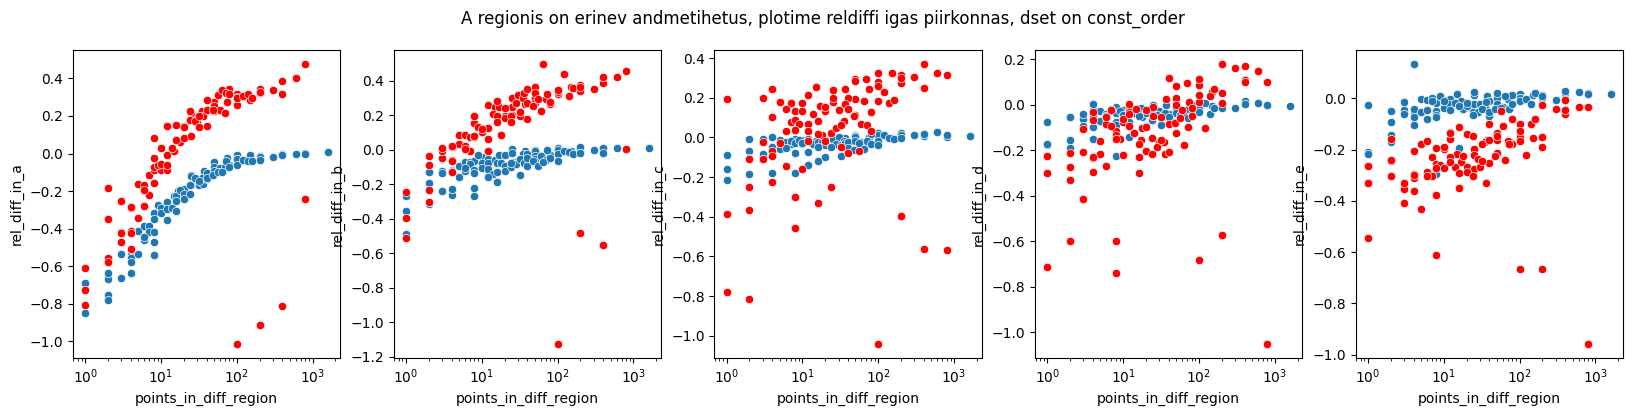

In [563]:
reg = "A"
dset = paths[0]
dfike = read_data(dset)
test_dfike = dfike[(dfike.region==reg)&(dfike.points_in_diff_region!=0)] #&(dfike.multiplier==2)

reg_a_pred = transform_and_predict(test_dfike, "a", True, True, False)
reg_b_pred = transform_and_predict(test_dfike, "b", True, True, False)
reg_c_pred = transform_and_predict(test_dfike, "c", True, True, False)
reg_d_pred = transform_and_predict(test_dfike, "d", True, True, False)
reg_e_pred = transform_and_predict(test_dfike, "e", True, True, False)

fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
# [a.set_ylim(-1, 1) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_a", ax=ax[0])
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_b", ax=ax[1])
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_c", ax=ax[2])
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_d", ax=ax[3])
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_e", ax=ax[4])

sns.scatterplot(x=test_dfike.points_in_diff_region, y=reg_a_pred, color="red", ax=ax[0])
sns.scatterplot(x=test_dfike.points_in_diff_region, y=reg_b_pred, color="red", ax=ax[1])
sns.scatterplot(x=test_dfike.points_in_diff_region, y=reg_c_pred, color="red", ax=ax[2])
sns.scatterplot(x=test_dfike.points_in_diff_region, y=reg_d_pred, color="red", ax=ax[3])
sns.scatterplot(x=test_dfike.points_in_diff_region, y=reg_e_pred, color="red", ax=ax[4])

plt.suptitle(f"{reg} regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas, dset on {dset.split('/')[-1].replace('.csv', '')}")
plt.show()

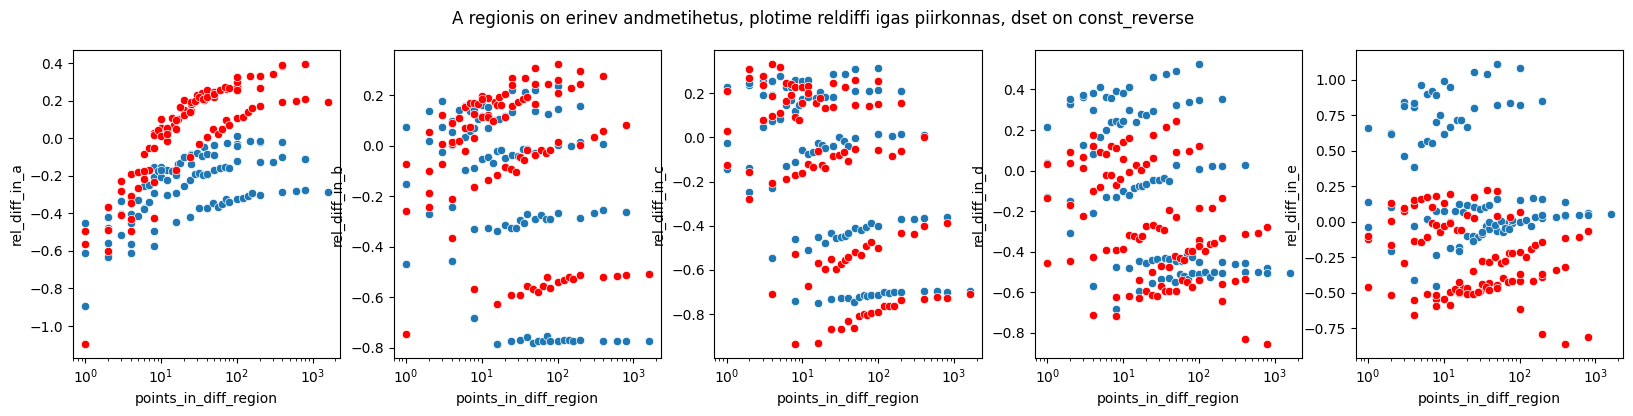

In [575]:
reg = "A"
dset = paths[1]
dfike = read_data(dset)
test_dfike = dfike[(dfike.region==reg)&(dfike.points_in_diff_region!=0)] #&(dfike.multiplier==2)

reg_a_pred = transform_and_predict(test_dfike, "a", True, True, False)
reg_b_pred = transform_and_predict(test_dfike, "b", True, True, False)
reg_c_pred = transform_and_predict(test_dfike, "c", True, True, False)
reg_d_pred = transform_and_predict(test_dfike, "d", True, True, False)
reg_e_pred = transform_and_predict(test_dfike, "e", True, True, False)

fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
# [a.set_ylim(-1, 1) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_a", ax=ax[0])
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_b", ax=ax[1])
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_c", ax=ax[2])
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_d", ax=ax[3])
sns.scatterplot(data = test_dfike, x="points_in_diff_region",y="rel_diff_in_e", ax=ax[4])


sns.scatterplot(x=test_dfike.points_in_diff_region.values, y=reg_a_pred.values, color="red", ax=ax[0])
sns.scatterplot(x=test_dfike.points_in_diff_region, y=reg_b_pred.values, color="red", ax=ax[1])
sns.scatterplot(x=test_dfike.points_in_diff_region.values, y=reg_c_pred, color="red", ax=ax[2])
sns.scatterplot(x=test_dfike.points_in_diff_region, y=reg_d_pred, color="red", ax=ax[3])
sns.scatterplot(x=test_dfike.points_in_diff_region, y=reg_e_pred, color="red", ax=ax[4])


plt.suptitle(f"{reg} regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas, dset on {dset.split('/')[-1].replace('.csv', '')}")
plt.show()

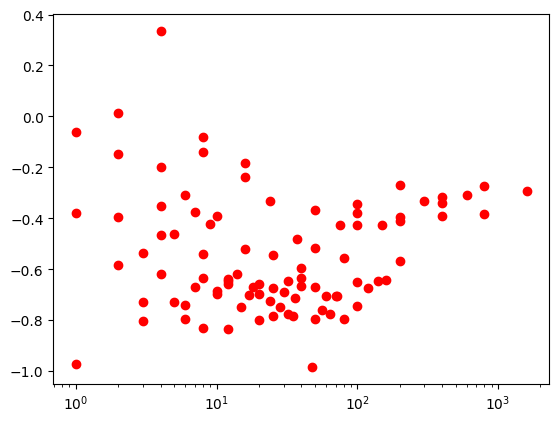

In [556]:
fig, ax = plt.subplots()
ax.set_xscale("log")
for a, b in zip(test_dfike.points_in_diff_region.values, reg_c_pred.values):
    ax.plot(a,b, 'ro')

In [229]:
letter = "A"
dfike = read_data(paths[2])
dfike["my_points"] =  (dfike["train_size"]/5 * dfike["multiplier"] * (dfike["region"] == letter)) + (dfike["train_size"]/5 * (dfike["region"] !=letter))
dfike["my_points"] += 1.0
dfike['my_points_m1']  = dfike["my_points"] ** (-1)
dfike["my_points_log"] = np.log(dfike["my_points"])
dfike["my_points_logm1"] = (np.log(dfike["my_points"])+1.0 ) ** (-1)

coef2 = (-0.170911703 * (dfike.my_points - np.min(dfike.my_points))) / (dfike.my_points * (np.max(dfike.my_points)-np.min(dfike.my_points)))
my_points_regular_kordajaga_ja_scaleeritud = coef2 * dfike.my_points
my_points_regular_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (0.366006906 * (dfike.my_points_m1 - np.min(dfike.my_points_m1))) / (dfike.my_points_m1 * (np.max(dfike.my_points_m1)-np.min(dfike.my_points_m1)))
my_points_m1_kordajaga_ja_scaleeritud = coef2 * dfike.my_points_m1
my_points_m1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (0.303310425 * (dfike.my_points_log - np.min(dfike.my_points_log))) / (dfike.my_points_log * (np.max(dfike.my_points_log)-np.min(dfike.my_points_log)))
my_points_log_kordajaga_ja_scaleeritud = coef2 * dfike.my_points_log
my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (-0.996713903 * (dfike.my_points_logm1 - np.min(dfike.my_points_logm1))) / (dfike.my_points_logm1 * (np.max(dfike.my_points_logm1)-np.min(dfike.my_points_logm1)))
my_points_logm1_kordajaga_ja_scaleeritud = coef2 * dfike.my_points_logm1
my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

my_points_kasitsi = my_points_regular_kordajaga_ja_scaleeritud+my_points_m1_kordajaga_ja_scaleeritud+my_points_log_kordajaga_ja_scaleeritud+my_points_logm1_kordajaga_ja_scaleeritud
my_points_kasitsi = my_points_logm1_kordajaga_ja_scaleeritud
dfike["logm1_combo"] = my_points_kasitsi

<AxesSubplot: xlabel='my_points_combo', ylabel='rel_diff_in_a'>

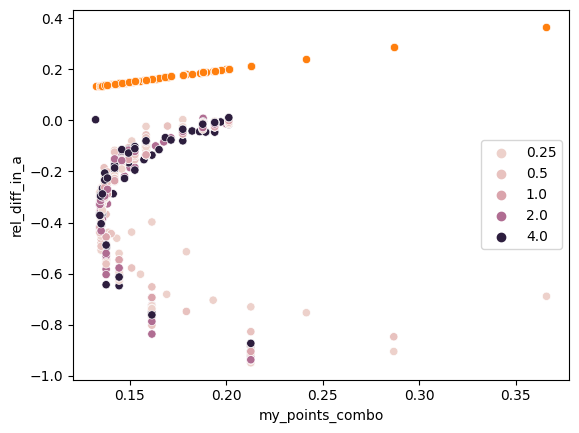

In [191]:
fig, ax = plt.subplots()
# ax.set_xscale("log")
sns.scatterplot(data = dfike, x="my_points_combo", y="rel_diff_in_"+letter.lower(), hue=multipliers, ax=ax)
sns.scatterplot(data = dfike, x="my_points_combo", y="my_points_combo", ax=ax)

<AxesSubplot: xlabel='my_points_combo', ylabel='rel_diff_in_a'>

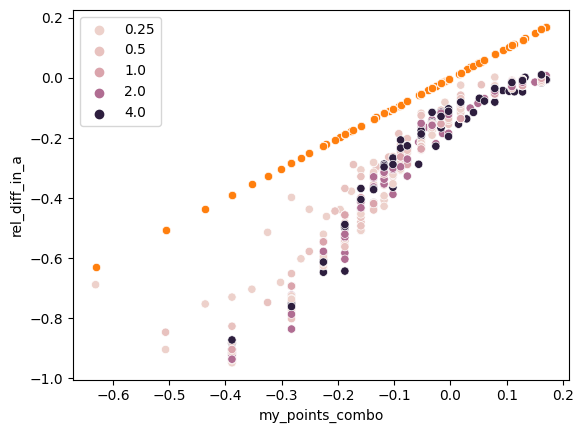

In [193]:
fig, ax = plt.subplots()
# ax.set_xscale("log")
sns.scatterplot(data = dfike, x="my_points_combo", y="rel_diff_in_"+letter.lower(), hue=multipliers, ax=ax)
sns.scatterplot(data = dfike, x="my_points_combo", y="my_points_combo", ax=ax)

In [202]:
dfike.columns

Index(['region', 'multiplier', 'train_size', 'random_seed', 'bpoints_in_a',
       'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
       'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c',
       'ext_bpoints_in_d', 'ext_bpoints_in_e', 'abs_diff_in_a',
       'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
       'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d',
       'rel_diff_in_e', 'raw_mean2_in_a', 'raw_mean2_in_b', 'raw_mean2_in_c',
       'raw_mean2_in_d', 'raw_mean2_in_e', 'raw_mean3_in_a', 'raw_mean3_in_b',
       'raw_mean3_in_c', 'raw_mean3_in_d', 'raw_mean3_in_e', 'mse_treeningul',
       'mse_grid_testil', 'mse_treening_andmete_teine_myra',
       'points_in_equal_regions', 'points_in_diff_region', 'total_points',
       'combo_name', 'my_points', 'my_points_m1', 'my_points_log',
       'my_points_logm1', 'my_points_combo'],
      dtype='object')

<AxesSubplot: xlabel='my_points_combo', ylabel='rel_diff_in_a'>

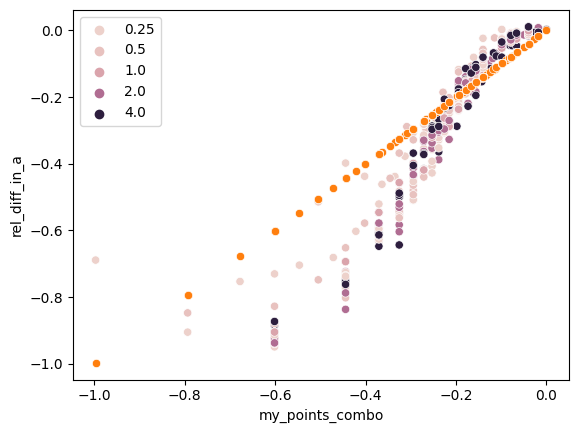

In [204]:
fig, ax = plt.subplots()
# ax.set_xscale("log")
sns.scatterplot(data = dfike, x="my_points_combo", y="rel_diff_in_"+letter.lower(), hue="multiplier", ax=ax)
sns.scatterplot(data = dfike, x="my_points_combo", y="my_points_combo", ax=ax)

In [52]:
scaleeritudX.my_points * 0.085575865

0       0.000000
1       0.000053
2       0.000053
3       0.000107
4       0.000107
          ...   
8025    0.010697
8026    0.021394
8027    0.032091
8028    0.042788
8029    0.085576
Name: my_points, Length: 8030, dtype: float64

In [57]:
coef2 = (0.085575865 * (suurX.my_points - np.min(suurX.my_points))) / (suurX.my_points * (np.max(suurX.my_points)-np.min(suurX.my_points)))

regular_kordajaga_ja_scaleeritud = coef2 * suurX.my_points
regular_kordajaga_ja_scaleeritud

0       0.000000
1       0.000053
2       0.000053
3       0.000107
4       0.000107
          ...   
8025    0.010697
8026    0.021394
8027    0.032091
8028    0.042788
8029    0.085576
Name: my_points, Length: 8030, dtype: float64

In [58]:
coef2 = (-0.661926834 * (suurX.my_points_m1 - np.min(suurX.my_points_m1))) / (suurX.my_points_m1 * (np.max(suurX.my_points_m1)-np.min(suurX.my_points_m1)))

m1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_m1
m1_kordajaga_ja_scaleeritud

0      -0.661927
1      -0.330757
2      -0.330757
3      -0.220366
4      -0.220366
          ...   
8025   -0.002882
8026   -0.001238
8027   -0.000688
8028   -0.000413
8029   -0.000000
Name: my_points_m1, Length: 8030, dtype: float64

In [66]:
coef2 = (0.279312127 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))

log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)
log_kordajaga_ja_scaleeritud

0       0.000000
1       0.026239
2       0.026239
3       0.041588
4       0.041588
          ...   
8025    0.200759
8026    0.226904
8027    0.242222
8028    0.253096
8029    0.279312
Name: my_points_log, Length: 8030, dtype: float64

In [69]:
kasitsi_iludus = regular_kordajaga_ja_scaleeritud+m1_kordajaga_ja_scaleeritud+log_kordajaga_ja_scaleeritud

1.0268148259999998